# Description

In this notebook we explore how skeleton data looks. In particular, we need to test whether we can generate satisfying smoothing for the skeleton data that doesn't impair time resolution

# Imports

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
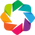

In [17]:
from pathlib import Path
import sys

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import correlate
from sklearn.metrics import mean_squared_error
import holoviews as hv
hv.extension('bokeh')


src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

from Ballpushing_utils import Experiment, Fly

from utils_behavior import Processing

from utils_behavior import Sleap_utils

In [2]:
ExampleFly_path = Path(
    "/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231130_TNT_Fine_2_Videos_Tracked/arena2/corridor5"
)

ExampleFly = Fly(ExampleFly_path, as_individual=True)

Config loaded with the following parameters:
debugging: False
experiment_type: Ctrl
time_range: None
success_cutoff: True
success_cutoff_method: final_event
tracks_smoothing: True
chamber_radius: 50
downsampling_factor: None
generate_random: False
random_exclude_interactions: True
random_interaction_map: full
interaction_threshold: (0, 45)
gap_between_events: 1
events_min_length: 1
dead_threshold: 30
adjusted_events_normalisation: 1000
significant_threshold: 5
success_threshold: 5
aha_moment_threshold: 20
success_direction_threshold: 25
final_event_threshold: 170
final_event_F1_threshold: 100
max_event_threshold: 10
pause_threshold: 5
pause_window: 5
pause_min_duration: 2
template_width: 96
template_height: 516
padding: 20
y_crop: (74, 0)
contact_threshold: (0, 13)
gap_between_contacts: 0.5
contact_min_length: 0.5
skeleton_tracks_smoothing: False
hidden_value: 9999
Ctrl has no particular configuration.


In [3]:
skeleton_data = ExampleFly.tracking_data.fly_skeleton

In [4]:
skeleton_data

,frame,time,object,x_Head,y_Head,x_Thorax,y_Thorax,x_Abdomen,y_Abdomen,x_Rfront,...,x_Lmid,y_Lmid,x_Rhind,y_Rhind,x_Lhind,y_Lhind,x_Rwing,y_Rwing,x_Lwing,y_Lwing
0,1,0.034483,fly_1,67.884010,388.104218,71.570183,400.012878,80.309036,416.225555,76.288376,...,48.095875,380.244720,96.705666,411.555939,63.933968,427.855591,87.944183,435.339142,87.650162,435.520111
1,2,0.068966,fly_1,67.879028,388.055237,71.562263,399.937836,80.279716,416.178192,76.357666,...,48.213337,379.920715,96.628120,411.494781,63.975681,427.832031,87.921387,435.338928,87.644135,435.511658
2,3,0.103448,fly_1,67.925056,388.007965,71.543503,399.881348,80.337837,416.192200,79.767433,...,51.479744,379.824219,96.609077,411.501617,64.005798,427.854340,87.932922,435.333221,87.629425,435.530579
3,4,0.137931,fly_1,67.834076,388.002106,71.550804,399.935730,80.287285,416.198547,72.464493,...,51.445644,380.056732,96.649521,411.442383,63.916481,427.913666,87.921356,435.355133,87.636917,435.534821
4,5,0.172414,fly_1,67.901337,388.050903,71.563240,399.945221,80.282196,416.182983,76.251999,...,NaN,NaN,96.619217,411.411041,63.971722,427.897247,87.931160,435.352722,87.656494,435.526245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104397,104398,3599.931034,fly_1,64.432693,92.376244,63.553719,104.314919,67.971550,127.878944,80.268120,...,NaN,NaN,80.368362,135.564697,NaN,NaN,60.097996,144.054138,NaN,NaN
104398,104399,3599.965517,fly_1,64.319832,95.696045,63.426910,107.672974,67.914017,128.450836,80.542480,...,NaN,NaN,80.122643,132.659302,NaN,NaN,59.831341,144.458771,NaN,NaN
104399,104400,3600.000000,fly_1,64.542717,96.011215,63.365150,107.880951,64.284950,128.554047,83.510551,...,NaN,NaN,79.644211,132.407578,NaN,NaN,55.924980,144.208191,NaN,NaN
104400,104401,3600.034483,fly_1,63.846230,95.632523,60.366535,107.489151,68.167313,128.096176,79.946098,...,NaN,NaN,79.883072,140.147369,NaN,NaN,63.474701,147.454025,NaN,NaN


# Functions to test smoothing parameters

Here we're gonna test the mean squared error and the time lag between smoothed and raw data to find the best smoothing parameter that reduce the tracking error-related noise while keeping time resolution.

In [9]:
def compute_time_lag(raw_data, smoothed_data, sampling_rate):
    correlation = correlate(smoothed_data, raw_data, mode="full")
    lag = correlation.argmax() - (len(raw_data) - 1)
    time_lag = lag / sampling_rate  # Convert lag to time
    return time_lag

In [10]:
def compute_error(raw_data, smoothed_data):
    mse = mean_squared_error(raw_data, smoothed_data)
    return mse

In [13]:
def test_filter_parameters(raw_data, sampling_rate, window_lengths, polyorders):
    results = []
    for wl in window_lengths:
        for po in polyorders:
            try:
                smoothed_data = Processing.savgol_lowpass_filter(raw_data, window_length=wl, polyorder=po)
                time_lag = compute_time_lag(raw_data, smoothed_data, sampling_rate)
                mse = compute_error(raw_data, smoothed_data)
                results.append((wl, po, time_lag, mse))
            except ValueError:
                print(f"Invalid parameters: window_length={wl}, polyorder={po}")
                continue  # Skip invalid parameter combinations
    return results

# Tests

In [15]:
# Define the parameters to test
window_lengths = [11, 21, 51, 101]  # Must be odd integers
polyorders = [1, 2, 3]
sampling_rate = ExampleFly.experiment.fps  # Replace with the actual sampling rate of your data

# Initialize a dictionary to store results for each keypoint
results = {}

# Iterate over each keypoint column in the skeleton_data
for column in skeleton_data.columns:
    if column.startswith("x_") or column.startswith("y_"):  # Filter keypoint columns
        raw_data = skeleton_data[column].dropna().values  # Remove NaN values
        if len(raw_data) < min(window_lengths):  # Skip if data is too short
            print(f"Skipping {column} as data length={len(raw_data)} is too short")
            continue

        # Test filter parameters for the current keypoint
        keypoint_results = test_filter_parameters(raw_data, sampling_rate, window_lengths, polyorders)

        # Store the results
        results[column] = keypoint_results

# Display results for each keypoint
for keypoint, keypoint_results in results.items():
    print(f"Results for {keypoint}:")
    for wl, po, time_lag, mse in keypoint_results:
        print(f"  Window Length: {wl}, Polyorder: {po}, Time Lag: {time_lag:.4f}s, MSE: {mse:.4f}")

Results for x_Head:
  Window Length: 11, Polyorder: 1, Time Lag: 0.0000s, MSE: 3.0555
  Window Length: 11, Polyorder: 2, Time Lag: 0.0000s, MSE: 1.0241
  Window Length: 11, Polyorder: 3, Time Lag: 0.0000s, MSE: 1.0241
  Window Length: 21, Polyorder: 1, Time Lag: 0.0000s, MSE: 9.1646
  Window Length: 21, Polyorder: 2, Time Lag: 0.0000s, MSE: 2.4929
  Window Length: 21, Polyorder: 3, Time Lag: 0.0000s, MSE: 2.4930
  Window Length: 51, Polyorder: 1, Time Lag: 0.0000s, MSE: 42.3026
  Window Length: 51, Polyorder: 2, Time Lag: 0.0000s, MSE: 11.8029
  Window Length: 51, Polyorder: 3, Time Lag: 0.0000s, MSE: 11.8023
  Window Length: 101, Polyorder: 1, Time Lag: 0.0000s, MSE: 80.4731
  Window Length: 101, Polyorder: 2, Time Lag: 0.0000s, MSE: 43.0230
  Window Length: 101, Polyorder: 3, Time Lag: 0.0000s, MSE: 43.0223
Results for y_Head:
  Window Length: 11, Polyorder: 1, Time Lag: 0.0000s, MSE: 3.1877
  Window Length: 11, Polyorder: 2, Time Lag: 0.0000s, MSE: 1.0431
  Window Length: 11, Polyor

In [16]:
# Define a function to find the best parameters
def find_best_parameters(results):
    best_parameters = {}
    for keypoint, keypoint_results in results.items():
        # Sort by MSE and then by time lag to prioritize low error and minimal lag
        sorted_results = sorted(keypoint_results, key=lambda x: (x[3], abs(x[2])))  # Sort by MSE, then time lag
        best_parameters[keypoint] = sorted_results[0]  # Take the best combination
    return best_parameters


# Find the best parameters for each keypoint
best_parameters = find_best_parameters(results)

# Display the best parameters for each keypoint
print("Best parameters for each keypoint:")
for keypoint, (wl, po, time_lag, mse) in best_parameters.items():
    print(f"{keypoint}: Window Length={wl}, Polyorder={po}, Time Lag={time_lag:.4f}s, MSE={mse:.4f}")

# Optionally, find the overall best parameters across all keypoints
overall_best = min(
    [(keypoint, wl, po, time_lag, mse) for keypoint, (wl, po, time_lag, mse) in best_parameters.items()],
    key=lambda x: (x[4], abs(x[3])),  # Sort by MSE, then time lag
)

print("\nOverall best parameters across all keypoints:")
print(
    f"Keypoint={overall_best[0]}, Window Length={overall_best[1]}, Polyorder={overall_best[2]}, "
    f"Time Lag={overall_best[3]:.4f}s, MSE={overall_best[4]:.4f}"
)

Best parameters for each keypoint:
x_Head: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=1.0241
y_Head: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=1.0430
x_Thorax: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=0.7545
y_Thorax: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=0.8184
x_Abdomen: Window Length=11, Polyorder=2, Time Lag=0.0000s, MSE=0.8449
y_Abdomen: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=0.8182
x_Rfront: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=4.2291
y_Rfront: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=3.6963
x_Lfront: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=4.6497
y_Lfront: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=4.3027
x_Rmid: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=35.4994
y_Rmid: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=19.7321
x_Lmid: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE=37.4629
y_Lmid: Window Length=11, Polyorder=3, Time Lag=0.0000s, MSE

In [29]:
skeletontrack = Sleap_utils.Sleap_Tracks(
    ExampleFly_path / "corridor5_preprocessed_full_body.h5", smoothed_tracks=True, smoothing_params=(11, 3)
)

skeletontrack.video

PosixPath('/mnt/upramdya_data/MD/MultiMazeRecorder/Videos/231130_TNT_Fine_2_Videos_Tracked/arena2/corridor5/corridor5_preprocessed.mp4')

In [12]:
skeletontrack = Sleap_utils.Sleap_Tracks(ExampleFly_path/"corridor5_preprocessed_full_body.h5", smoothed_tracks=True, smoothing_params=(11,3)).objects[0].dataset

In [13]:
skeletontrack

,frame,time,object,x_Head,y_Head,x_Thorax,y_Thorax,x_Abdomen,y_Abdomen,x_Rfront,...,x_Lmid,y_Lmid,x_Rhind,y_Rhind,x_Lhind,y_Lhind,x_Rwing,y_Rwing,x_Lwing,y_Lwing
0,1,0.034483,object_1,67.883000,388.123454,71.579118,400.013918,80.305974,416.216889,77.147005,...,53.001408,377.292026,96.699699,411.566457,63.964396,427.839475,87.937121,435.338787,87.646272,435.518376
1,2,0.068966,object_1,67.890149,388.033960,71.555662,399.936137,80.297882,416.197908,75.975120,...,53.001408,377.292026,96.647924,411.501147,63.951614,427.854425,87.928084,435.340092,87.640488,435.520793
2,3,0.103448,object_1,67.890594,387.994581,71.543122,399.899831,80.298598,416.187912,75.815805,...,53.001408,377.292026,96.616953,411.460449,63.948641,427.870430,87.927880,435.341223,87.640298,435.523667
3,4,0.137931,object_1,67.888168,387.995875,71.540056,399.896545,80.305090,416.184864,76.409135,...,53.001408,377.292026,96.602310,411.440089,63.953897,427.884819,87.932869,435.342244,87.643378,435.526662
4,5,0.172414,object_1,67.886704,388.028402,71.545021,399.917819,80.314328,416.186726,77.495187,...,53.001408,377.292026,96.599517,411.435790,63.965805,427.894924,87.939408,435.343223,87.647407,435.529443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104397,104398,3599.931034,object_1,65.429249,92.795287,63.572777,104.706530,66.568064,126.481973,81.660338,...,52.790958,183.228769,79.875090,133.085253,53.827085,204.615377,58.835454,143.090029,61.025247,131.052398
104398,104399,3599.965517,object_1,65.114842,94.138149,63.176824,106.024493,65.758342,127.569168,81.687185,...,52.790958,183.228769,79.721687,134.561336,53.827085,204.615377,57.646730,144.191724,61.025247,131.052398
104399,104400,3600.000000,object_1,64.663946,94.881480,62.491479,106.760805,65.727888,128.305100,81.768356,...,52.790958,183.228769,79.745755,136.054927,53.827085,204.615377,57.994908,145.022209,61.025247,131.052398
104400,104401,3600.034483,object_1,64.092666,94.776570,61.444595,106.672789,66.801734,128.555268,81.962678,...,52.790958,183.228769,79.998354,137.670235,53.827085,204.615377,60.393970,145.490973,61.025247,131.052398


# Looking at a small subset of data

Will be useful in order to compare smoothed and raw data

In [ ]:
# Plot sns curves of smoothed and raw data for a specific keypoint across 10 seconds

def plot_keypoint_data(raw_data, smoothed, keypoint, start_time=0, end_time=10):
    # Extract the x and y coordinates for the specified keypoint
    raw_data = skeleton_data[f"y_{keypoint}"].dropna().values
    smoothed_data = skeletontrack[f"y_{keypoint}"].dropna().values

    # crop the smoothed data to the same length as the raw data
    smoothed_data = smoothed_data[:len(raw_data)]

    # Create a time array based on the sampling rate
    time = np.arange(len(raw_data)) / ExampleFly.experiment.fps

    # Filter the data for the specified time range
    mask = (time >= start_time) & (time <= end_time)
    time = time[mask]
    raw_data = raw_data[mask]
    smoothed_data = smoothed_data[mask]

    # Plot the data using seaborn
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=time, y=raw_data, label='Y Coordinate', color='blue')
    sns.lineplot(x=time, y=smoothed_data, label='Y Coordinate_smoothed', color='orange')
    plt.title(f"Keypoint Data for {keypoint} from {start_time}s to {end_time}s")
    plt.xlabel("Time (s)")
    plt.ylabel("Coordinate Value")
    plt.legend()
    plt.show()

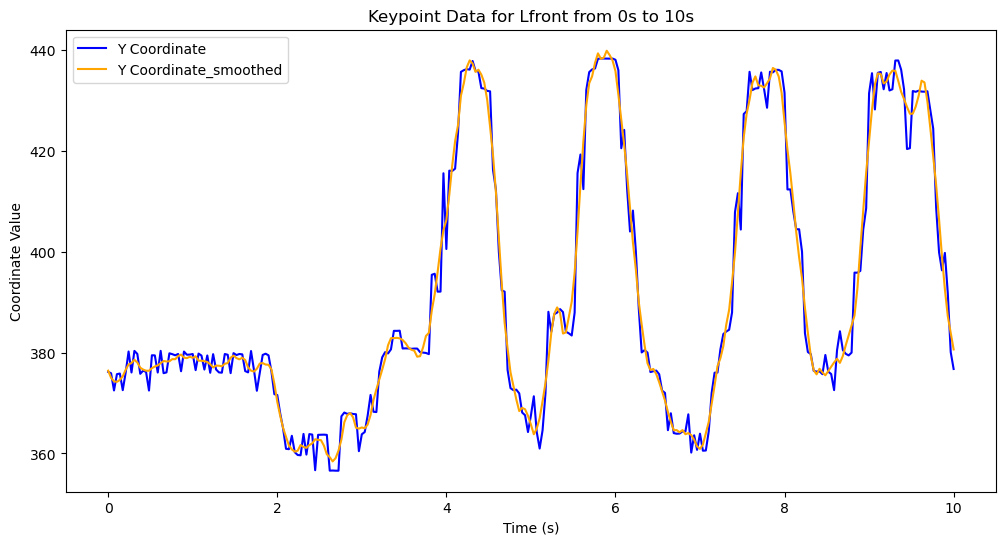

In [28]:
Key = "Lfront"

plot_keypoint_data(skeleton_data, skeletontrack, Key, start_time=0, end_time=10)

## Saving the smoothed test 

# Generating a Hv curve

Holoviews allow precise zooming so we'll use it to visually explore the smoothed vs raw data

In [19]:
# Plot the raw and smoothed data for a specific keypoint

Key = "Lfront"

raw_data = skeleton_data[f"x_{Key}"].dropna().values
smoothed_data = skeletontrack[f"x_{Key}"].dropna().values
# crop the smoothed_data to match the length of raw_data
smoothed_data = smoothed_data[: len(raw_data)]
time = np.arange(len(raw_data)) / ExampleFly.experiment.fps  # Time vector

Curves = hv.Curve((time, raw_data), label="Raw Data").opts(
    title=f"Raw and Smoothed Data for {Key}",
    xlabel="Time (s)",
    ylabel="Position",
    color="blue",
    width=800,
    height=400,
)
smoothed_curve = hv.Curve((time, smoothed_data), label="Smoothed Data").opts(
    color="red",
    width=800,
    height=400,
)
# Overlay the curves

overlay = Curves * smoothed_curve

# Save the plot as html
hv.save(overlay, "/mnt/upramdya_data/MD/Pictures/smoothed_data_plot.html", backend="bokeh")

# Generating a labelled clip for tracking

In [28]:
Sleap_utils.generate_annotated_video(
    video=skeletontrack.video,
    sleap_tracks_list=[skeletontrack],
    output_path=ExampleFly_path / "Annotated_Video.mp4",
)

No CUDA devices found, falling back to CPU processing.


Processing frames: 100%|██████████| 104402/104402 [41:49<00:00, 41.59it/s] 


: 